# HW 6
## 3. Histogram

In [2]:
!pip install pycuda

import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule

import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached pycuda-2022.2.tar.gz (1.7 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Using cached Mako-1.2.4-py3-none-any.whl (78 kB)
  Using cached pytools-2022.1.13.tar.gz (71 kB)
  Created wheel for pycuda: filename=pycuda-2022.2-cp38-cp38-linux_x86_64.whl size=646470 sha256=c05381eb85912d1d96ec9bb1f07ffb9d73add04a8ceb28129df4f37b42473c02
  Stored in directory: /root/.cache/pip/wheels/ef/0e/11/809b20ee6df2e1c63ef52b3dcf2b7386b900d4f58548f0484e
  Created wheel for pytools: filename=pytools-2022.1.13-py2.py3-none-any.whl size=66024 sha256=bbd9f66b52ec973c54b14d8406894a8e0d3edeb0d615d7a5033c81a51beafbf5
  Stored in directory: /root/.cache/pip/wheels/b5/c1/bb/26ba70fb9d10f195249ef4e170a92ae83e7534e55b67786fd9
Successfully built pycuda pytools


In [3]:
h_img = cv2.imread('cat_2.jpg', 0).astype(np.int32)
d_img = cuda.mem_alloc(h_img.nbytes)
cuda.memcpy_htod(d_img, h_img)
h_img.shape

(800, 1200)

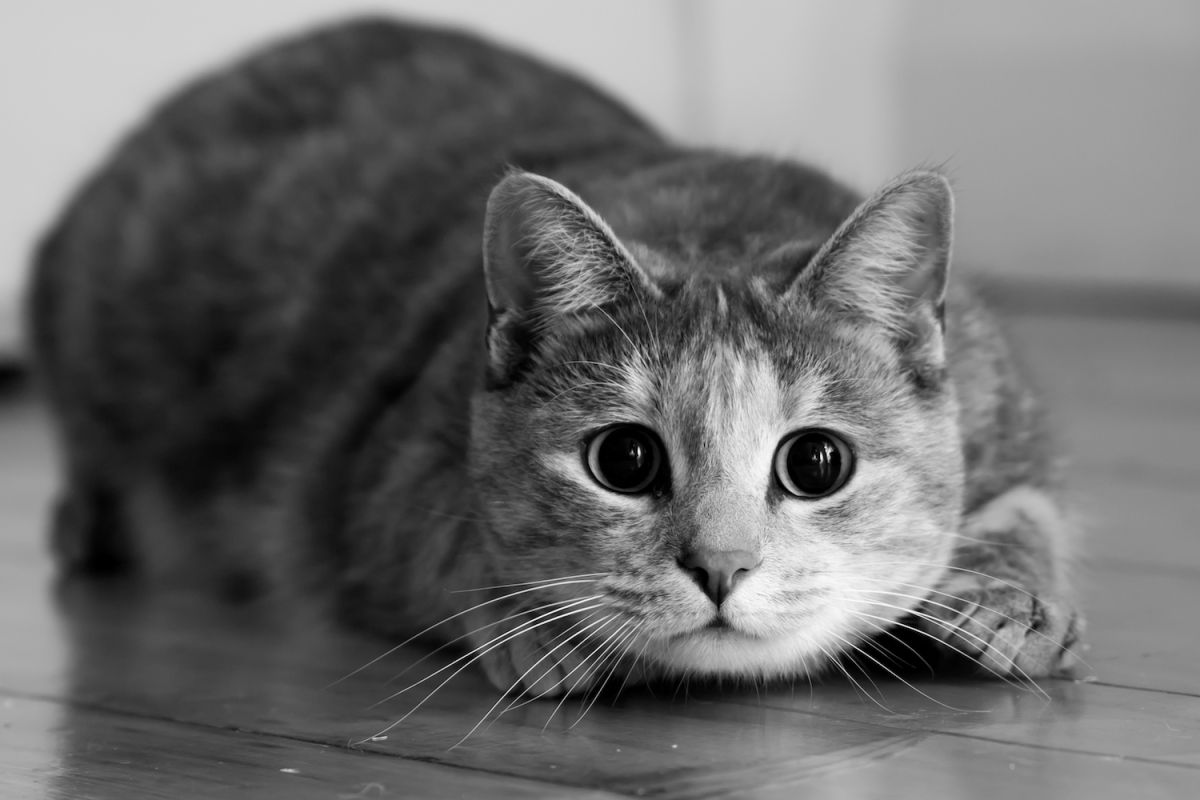

In [4]:
cv2_imshow(h_img)

In [5]:
rows = h_img.shape[1]
cols = h_img.shape[0]
block_size = 32
block = (block_size, block_size, 1)
grid = ((rows + block_size - 1) // block[0], (cols + block_size - 1) // block[1])

In [6]:
bin_count = 128

h_bins = np.linspace(0, 256, bin_count + 1, dtype=np.int32)
d_bins = cuda.mem_alloc(h_bins.nbytes)
cuda.memcpy_htod(d_bins, h_bins)
h_bins

array([  0,   2,   4,   6,   8,  10,  12,  14,  16,  18,  20,  22,  24,
        26,  28,  30,  32,  34,  36,  38,  40,  42,  44,  46,  48,  50,
        52,  54,  56,  58,  60,  62,  64,  66,  68,  70,  72,  74,  76,
        78,  80,  82,  84,  86,  88,  90,  92,  94,  96,  98, 100, 102,
       104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128,
       130, 132, 134, 136, 138, 140, 142, 144, 146, 148, 150, 152, 154,
       156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180,
       182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206,
       208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232,
       234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256],
      dtype=int32)

In [7]:
h_hist = np.zeros(bin_count, dtype=np.int32)
d_hist = cuda.mem_alloc(h_hist.nbytes)
cuda.memcpy_htod(d_hist, h_hist)
h_hist

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [8]:
histogramModule = SourceModule("""
  __global__ void histogram(const int binCount, const int *bins, const int rows, const int cols, const int *img, int *hist)
  {
    unsigned int xIdx = threadIdx.x + blockIdx.x * blockDim.x;
    unsigned int yIdx = threadIdx.y + blockIdx.y * blockDim.y;
    if (yIdx < rows && xIdx < cols) {
        int val = img[yIdx * cols + xIdx];
        for (int i = 0; i < binCount; i++) {
            if (val >= bins[i] && val < bins[i + 1]) {
                atomicAdd(&(hist[i]), 1);
            }
        }
    }
  }
  """)

histogram = histogramModule.get_function('histogram')

In [9]:
histogram(
    np.int32(bin_count), 
    d_bins,
    np.int32(h_img.shape[0]), 
    np.int32(h_img.shape[1]), 
    d_img, 
    d_hist, 
    block=block,
    grid=grid
)
cuda.memcpy_dtoh(h_hist, d_hist)

In [10]:
cuda.memcpy_dtoh(h_hist, d_hist)
h_hist

array([ 4664,  2151,  1980,  2163,  2333,  2592,  3145,  3508,  3262,
        3615,  4379,  5382,  6922,  7383,  8027,  9176, 10478, 11424,
       12237, 11623, 11472, 10774, 11422, 11852, 12806, 13460, 13631,
       13251, 14040, 14294, 15268, 15853, 16908, 17095, 17721, 17087,
       15671, 15281, 14348, 12260, 10597,  9592,  9419,  9260,  9010,
        8612,  7627,  7728,  7147,  6847,  7095,  6972,  6323,  5990,
        5576,  5291,  5178,  5302,  5527,  5654,  5856,  6344,  6405,
        6928,  8436,  9911,  8918,  8906, 12081, 15605, 11720, 10666,
        8379,  8401,  9444, 10123,  9940, 12025, 13381, 11316, 14296,
       12111, 10338, 10058,  9129,  7256,  7305,  6579,  5505,  3774,
        3672,  3757,  4004,  4502,  5848,  8793,  6461,  4847,  4923,
        5071,  5476,  8625,  6140, 11566, 21871, 10060,  1581,  1507,
        1412,  1321,  1339,  1303,  1215,  1042,   969,   943,   829,
         923,   861,   762,   695,   441,   249,   116,    43,    10,
           2,     0]

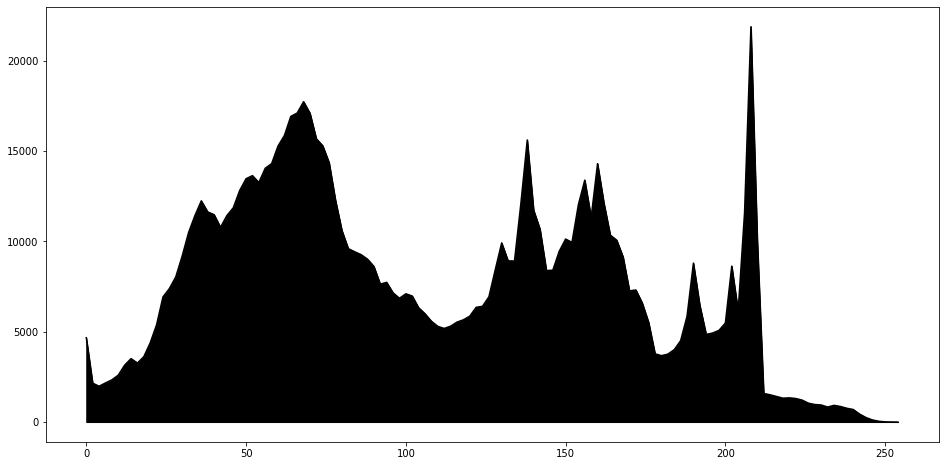

In [11]:
plt.figure(figsize=(16, 8))
plt.plot(h_bins[:-1], h_hist, c='black')
plt.fill_between(h_bins[:-1], h_hist, color='black')
